# Functional MRS 

Play with time series modelling of FMRS



## 1. Load FMRS data

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import glob,os
from fsl_mrs.utils import mrs_io as io

folder   = '/Users/saad/Desktop/Spectroscopy/FMRS/Jacob_data'
filelist = glob.glob(os.path.join(folder,'RAWFORMAT','run_???.RAW'))

FIDlist = []
for file in filelist:
    FID,FIDheader = io.read_FID(file)
    FIDlist.append(FID)
    
basisfile               = os.path.join(folder,'7T_slaser36ms_2013_oxford_tdcslb1_ivan.BASIS')
basis,names,basisheader = io.read_basis(basisfile)

# # Resample basis
from fsl_mrs.utils import misc
basis = misc.ts_to_ts(basis,basisheader['dwelltime'],FIDheader['dwelltime'],FID.shape[0])


# 2. Quick fit to average data

[30.568660986778177, -15.629618727730442]


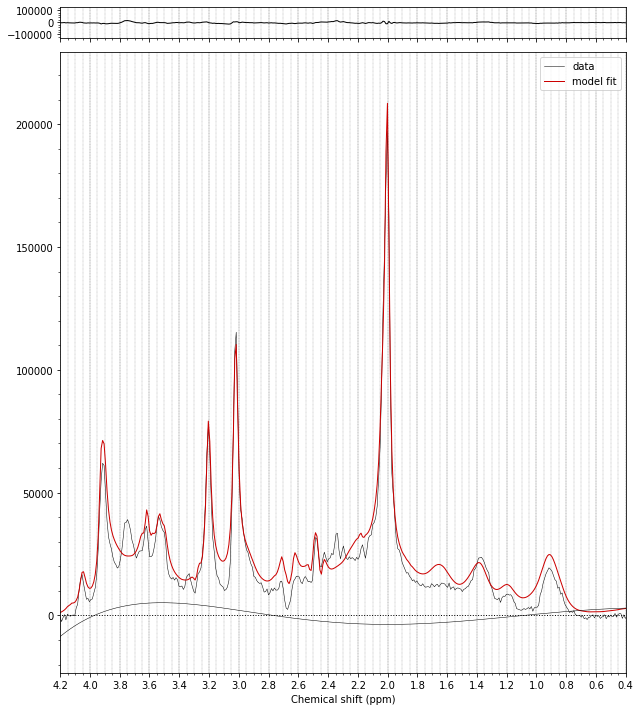

In [11]:
from fsl_mrs.core import MRS
from fsl_mrs.utils import fitting
import warnings
warnings.filterwarnings("ignore")

# Create MRS object
FID  = sum(FIDlist)/len(FIDlist)
args = {'FID'   : FID,
        'basis' : basis,
        'names' : names,
        'bw'    : FIDheader['bandwidth'],
        'cf'    : FIDheader['centralFrequency']}
mrs  = MRS(**args)

# Fit 
Fitargs = {'method':'Newton',
          'baseline_order':5,
          'ppmlim':(.2,4.2)}
res_avg = fitting.fit_FSLModel(mrs,**Fitargs)

# Plot fit
from fsl_mrs.utils import plotting
_ = plotting.plot_fit(mrs,pred=res_avg.pred,
                      baseline=res_avg.baseline)


# 3. Fit every time point separately


In [4]:
# Temporal smoothing of FIDs
sFIDlist = misc.smooth_FIDs(FIDlist,window=5)

MRSargs = {'names':names,'basis':basis,'bw':FIDheader['bandwidth'],'cf':FIDheader['centralFrequency']}

all_res = []
for idx,fid in enumerate(sFIDlist):    
    print('{}/{}'.format(idx+1,len(FIDlist)),end='\r')
    mrs = MRS(FID=fid,**MRSargs)
    res = fitting.fit_FSLModel(mrs,x0=res_avg.params,**Fitargs)
    all_res.append(res)


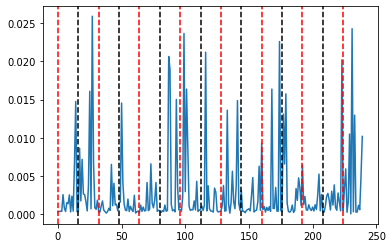

In [5]:
# Let's look at the time course of metabs


metab   = ['Glu','Gln']
norm    = ['Cr','PCr']

norm_ts = [sum([res.conc[res.names.index(m)] for m in norm]) for res in all_res]
conc_ts = [sum([res.conc[res.names.index(m)] for m in metab]) for res in all_res]
conc_ts_norm = [c/n for (c,n) in zip(conc_ts,norm_ts)]


plt.plot(conc_ts_norm)
for xx in range(16,240,32):
    plt.axvline(x=xx, color='k', linestyle='--')
for xx in range(0,240,32):
    plt.axvline(x=xx, color='r', linestyle='--')


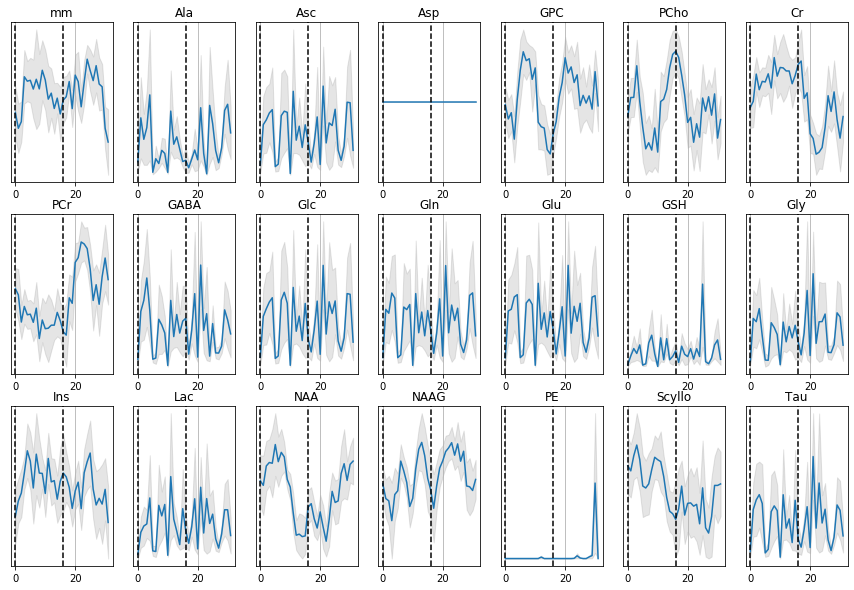

In [6]:

x = np.repeat([0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],16,axis=0).flatten()

def stim_avg(data,stim):
    grot = []
    for i in range(240):
        if stim[i]==1 and stim[i-1]==0:
            grot.append(data[i:i+32])

    grot = np.asarray(grot)
    m    = np.mean(grot,axis=0)
    s    = np.std(grot,axis=0) / np.sqrt(grot.shape[0])
    return m,s



plt.figure(figsize=(15,10))
for idx,name in enumerate(names):
    met = [res.conc_cr_pcr[res.names.index(name)] for res in all_res]    
    m,s = stim_avg(np.array(met),x)
    
    plt.subplot(3,7,idx+1)
    plt.plot(range(m.size),m, '-')
    plt.fill_between(range(m.size),m-s,m+s,color='gray', alpha=0.2)
    plt.grid()
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axvline(x=16, color='k', linestyle='--')
    plt.title(name)
    plt.yticks([])
    

In [ ]:
# Compare linear and nonlinear fit

from fsl_mrs.utils.models import FSLModel_transform_basis

args = {'x'  : res_avg.params,
        'nu' : mrs.frequencyAxis,
        't'  : mrs.timeAxis,
        'm'  : basis,
        'G'  : res.metab_groups,
        'g'  : res.g}

M = FSLModel_transform_basis(**args)

# extract ppmlim
ppmlim = (.2,4.2)
Mfreq  = np.fft.fft(M,axis=0)
Spec   = np.fft.fft(np.asarray(sFIDlist).T,axis=0)
first,last = mrs.ppmlim_to_range(ppmlim)
Mfreq = Mfreq[first:last,:]
Spec  = Spec[first:last,:]

desmat   = np.concatenate((np.real(Mfreq),np.imag(Mfreq)),axis=0)
y        = np.concatenate((np.real(Spec),np.imag(Spec)),axis=0)

import scipy.optimize.nnls as nnls
betas=[]
for i in range(y.shape[1]):
    betas.append(nnls(desmat,y[:,i]))

# betas = np.linalg.pinv(desmat)@y


In [ ]:
i = np.random.randint(21)
# i = names.index('Glu')
grot1 = [res.params[i] for res in all_res]
grot2 = [b[0][i] for b in betas]
# grot2 = betas[i,:]

plt.plot(grot1,grot2,'.')
print(names[i])

In [ ]:
i = names.index('Glu')
grot2 = [b[0][i] for b in betas]

m,s = stim_avg(np.array(grot2),x)
grot = stim_list(np.array(grot2),x)

plt.plot(range(m.size),grot.T,'k',alpha=.1)

plt.plot(range(m.size),m, '-')
plt.fill_between(range(m.size),m-s,m+s,color='blue', alpha=0.2)
plt.grid()
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=16, color='k', linestyle='--')
plt.yticks([])
plt.title(names[i])



In [ ]:
names

In [ ]:
grot = np.array([res.conc_cr_pcr for res in all_res])

n1 = np.sum(x==1)
n0 = np.sum(x==0)
m1 = np.mean(grot[x==1,:],axis=0)
m0 = np.mean(grot[x==0,:],axis=0)
s2 = (np.sum((grot-m1)**2)+np.sum((grot-m0)**2))/(n1+n0-2)
tstat  = (m1-m0) / np.sqrt(s2/n1+s2/n0)


_ = plt.plot(tstat,range(len(names)))
_ = plt.yticks(ticks=range(len(names)),labels=names)

In [ ]:
from scipy.stats import t
from scipy.stats import norm

zstat = norm.interval(t.cdf(tstat,df=n1+n0-2))
zstat[1]
_ = plt.plot(zstat[1],range(len(names)))
_ = plt.yticks(ticks=range(len(names)),labels=names)

# Play with dynamic model

tau.dx/dt = -x+diag(a)*u
y(t) = A*x(t)+N(0,sign^2)

In [ ]:
from fsl_mrs.utils.models import FSLModel_transform_basis

args = {'x'  : res_avg.params,
        'nu' : mrs.frequencyAxis,
        't'  : mrs.timeAxis,
        'm'  : basis,
        'G'  : res_avg.metab_groups,
        'g'  : res_avg.g}

M = FSLModel_transform_basis(**args)

# extract ppmlim
ppmlim = (.2,4.2)
Mfreq  = np.fft.fft(M,axis=0)
Spec   = np.fft.fft(np.asarray(sFIDlist).T,axis=0)
first,last = mrs.ppmlim_to_range(ppmlim)
Mfreq = Mfreq[first:last,:]
Spec  = Spec[first:last,:]

A    = np.concatenate((np.real(Mfreq),np.imag(Mfreq)),axis=0)
y    = np.concatenate((np.real(Spec),np.imag(Spec)),axis=0)





In [ ]:
from scipy.integrate import odeint

m  = A.shape[1]
u  = np.repeat([0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],16,axis=0).flatten()
tt = np.arange(u.size)

def xfun(tau,a):
    def f(x,t,tau,a):
        ut =u[int(np.floor(t))]
        dxdt = (-x+a*ut+res_avg.conc)/tau
        return dxdt
    sol = odeint(f,res_avg.conc,tt,args=(tau,a))
    return sol

def forward(tau,a):
    x    = xfun(tau,a)
    pred = A@x.T
    return pred

def logpr(x):
    return 0

def errfunc(x):
    tau  = x[0:m]
    a    = x[m:]
    pred = forward(tau,a)
    return np.mean((y-pred)**2)
    
from scipy.optimize import minimize
x0 = np.asarray([np.random.rand(m),np.random.rand(m)]).flatten()

bnds = []
for i in range(x0.size):
    bnds.append((0,np.inf))
# res = minimize(errfunc, x0, method='TNC',bounds=bnds)
# res = minimize(errfunc, x0, method='Powell')



In [ ]:

def logpr(x):
    return 0

def loglik(x):
    tau  = x[0:m]
    a    = x[m:]
    pred = forward(tau,a)
    return np.mean((y-pred)**2)

from fsl_mrs.utils import mh
MH = mh.MH(loglik,logpr,njumps=100,burnin=100,sampleevery=2)
MH.fit(x0,verbose=True,LB=np.zeros(2*m))


In [ ]:
def xfun(tau,a):
    def f(x,t,tau,a):
        ut = np.interp(t,tt,u) #u[int(np.floor(t))]
        dxdt = (-x+a*ut+res_avg.conc)/tau
        return dxdt
    sol = odeint(f,0*res_avg.conc,tt,args=(tau,a))
    return sol

tau = 4*np.ones(m)
a   = 400*np.ones(m)
_ = plt.plot(xfun(tau,a)[:,0])
_ = plt.plot(u*100)



In [ ]:
# Two options:
# 1. Continuous dynamic system-style equation:
#    tau.dc/dt = -c(t) + c0. (1 + a.u(t))
#         y(t) = A.c(t)
#
# 2. Discrete model
# 
#    c[i] = c[i-1] + N(0,sig^2)
#    y[i] = A.c[i] + N(0,sign^2)
#
# free parameters model 1 : {tau,c0,a}
# free parameters model 2 : {c[0],sig,sign}

